In [8]:
cd D:\Project\diffusiontrack_MOT

D:\Project\diffusiontrack_MOT


In [9]:
import torch
from easydict import EasyDict

from Code.Detector.Default_YOLO import Default_YOLO
from Code.Dataset.PreprocessingData import preprocessing_DanceTrack, preprocessing_DanceTrack1
from Code.Dataset.DiffMOTDataset import DiffMOTDataset, DiffMOTDataLoader

In [10]:
from easydict import EasyDict


# Initialize args with parameters using EasyDict
args = EasyDict({
    "path_yolo": 'yolov8n.pt',
    "path_data": r"Data/DanceTrack",
    "k_frame": 4,
    "batch_size": 4,
    "preprocess_workers": 0,
    "eps": 0.001,
    "lr": 0.0001,
    "data_dir": './outputs',
    "diffnet": 'HMINet',
    "interval": 5,
    "augment": True,
    "encoder_dim": 256,
    "tf_layer": 3,
    "epochs": 3,
    "seed": 123,
    "train": True,
    "val": True,
    "test": True,
    "test_index": 8,
    "eval_mode": False,
    "gpus": [i for i in range(4) if i < torch.cuda.device_count()]
})


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [12]:
detector_model = Default_YOLO(args.path_yolo)

In [ ]:
# # Preprocessing dataset for train and validation
trainer = ["train", "val", "train2"]
preprocessing_DanceTrack1(seq_root=args.path_data, trainer= trainer, detector_model= detector_model)
# #give train2 be the test set

In [15]:
if args.test_index != None:
    from torch.utils.data import Subset

    print(f"Test for {args.test_index} cases")


    # Assuming your dataset is already defined as `train_dataset`
    subset_indices = list(range(args.test_index))  # Get the first 16 indices
    train_dataset = DiffMOTDataset(path=args.path_data + "/train/trackers_gt_t_1", config=args)
    train_subset = Subset(train_dataset, subset_indices)

    # Create a DataLoader with the subset
    train_data_loader = DiffMOTDataLoader(train_subset, config=args)
    val_data_loader = train_data_loader
    test_data_loader = train_data_loader
else:
    if args.train:
        print("Train Dataset: " + args.path_data + "/train")
        train_dataset = DiffMOTDataset(path=args.path_data + "/train/trackers_gt_t_1", config=args)
        train_data_loader = DiffMOTDataLoader(train_dataset, config=args)

    if args.val:
        print("Validation Dataset: " + args.path_data + "/val")
        val_dataset = DiffMOTDataset(path=args.path_data + "/val/trackers_gt_t_1", config=args)
        val_data_loader = DiffMOTDataLoader(val_dataset, config=args)

    if args.test:
        print("Test Dataset: " + args.path_data + "/train2")
        test_dataset = DiffMOTDataset(path=args.path_data + "/train2/trackers_gt_t_1", config=args)
        test_data_loader = DiffMOTDataLoader(test_dataset, config=args)


print("Example dataset:")
train_dataset[0]


Test for 8 cases
24
Example dataset:


{'cur_gt': array([          0,           7,     0.24479,     0.69769,    0.096875,     0.14167,           1,        1080,        1920,    -0.15478,    0.069725,    -0.18855,    -0.24389,   -0.014795,     0.25148,    0.065826,    -0.25126,     0.10181,     0.27062,    -0.26886,     0.55087,     0.36207,   -0.074506,     -0.2026,
           -0.10009,    -0.24239,   -0.083431,      0.2404,   -0.041867,   -0.091798,    -0.16743,      0.4001,      1.1133,    -0.12544,      1.7962,    0.010487,     0.98165,     0.21596,     0.84733,    -0.21327,    -0.17922,    -0.17279,     -0.2646,   -0.097774,      0.4643,     -0.1425,      0.3174,       0.847,
          -0.011663,    -0.14858,    -0.26796,    -0.26056,     0.05094,    -0.26927,     0.19909,    -0.16911,     0.56699,    -0.14481,   -0.023477,     0.39609,   -0.060917,    -0.13118,    -0.16963,     -0.1676,      1.1674,    0.034968,    0.000172,     0.11149,     -0.1821,      0.8661,     0.68167,       1.591,
           0.079188], dtype=fl

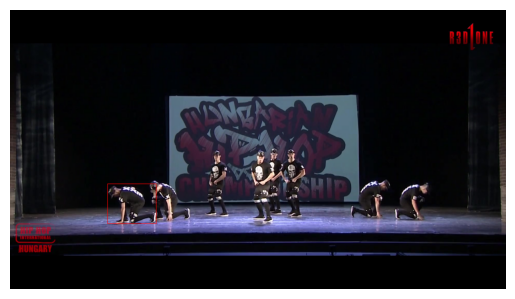

In [21]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

def original_shape(track, img_w, img_h):
    if len(track.shape) == 1:
        track = np.expand_dims(track, axis=0)

    track[:, 0::2] = track[:, 0::2] * img_w
    track[:, 1::2] = track[:, 1::2] * img_h
    track[:, 0] = track[:, 0] - track[:, 2] / 2
    track[:, 1] = track[:, 1] - track[:, 3] / 2

    return np.round(track, decimals=1)

from PIL import Image, ImageDraw
import numpy as np

def visualize_bbox(image_path, bbox):
    """
    Visualize a bounding box on an image.

    Parameters:
    - image_path (str): Path to the image file.
    - bbox (list or tuple): Bounding box coordinates in the format [x, y, width, height],
      where (x, y) is the top-left corner of the bounding box.
    """
    # Open the image
    image = Image.open(image_path)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Handle the case where bbox might be a 2D array
    if hasattr(bbox, "shape") and len(bbox.shape) == 2:
        bbox = bbox[0]

    # Calculate the bottom-right corner of the bounding box
    x, y, width, height = bbox
    x2, y2 = x + width, y + height

    # Draw the bounding box
    draw.rectangle([x, y, x2, y2], outline="red", width=2)

    # Show the image
    image.show()


    # Display the image with matplotlib
    plt.imshow(image)
    plt.axis("off")  # Hide axis for a cleaner look
    plt.show()

# Example usage
# Assuming `agent.train_dataset[30]` provides necessary data
item = train_dataset[3]
bbox = original_shape(item['cur_bbox'], item['width'], item['height'])
image_path = item['image_path']

visualize_bbox(image_path, bbox)


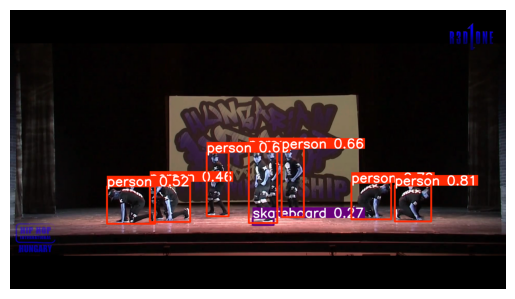

In [ ]:
frame_path = r'Data/DanceTrack/train/dancetrack0002\\img1\\00000007.jpg'
result = detector_model.get_object(frame_path)
obj_feats = result.feats
img_result = result.plot()
boxes = result.boxes.data

import matplotlib.pyplot as plt
plt.imshow(img_result)
plt.axis('off')  # Hide axes
plt.show()

# for reID

In [ ]:
from Code.Dataset.PreprocessingData import mkdirs

import os
import numpy as np
import cv2

In [ ]:
# def preprocessing_DanceTrack(seq_root, trainer):
seq_root = args.path_data
trainer= ["train"]

for type in trainer:
    label_root = os.path.join(seq_root, 'reid_gt_t', type)
    mkdirs(label_root)

    seq_root_tr = os.path.join(seq_root, type)
    
    # Filter out hidden files like .DS_Store
    seqs = [s for s in os.listdir(seq_root_tr) if not s.startswith('.') and "gt_t" not in s]

    for seq in seqs:
        print(seq)
        seq_info_path = os.path.join(seq_root_tr, seq, 'seqinfo.ini')

        if not os.path.exists(seq_info_path):
            print(f"Warning: {seq_info_path} not found, skipping sequence '{seq}'.")
            continue
        
        with open(seq_info_path) as f:
            seq_info = f.read()

        # Extract dimensions (only do this once per sequence)
        seq_width = int(seq_info[seq_info.find('imWidth=') + 8:seq_info.find('\nimHeight')])
        seq_height = int(seq_info[seq_info.find('imHeight=') + 9:seq_info.find('\nimExt')])

        gt_txt = os.path.join(seq_root_tr, seq, 'gt', 'gt.txt')

        if not os.path.exists(gt_txt):
            print(f"Warning: {gt_txt} not found for sequence '{seq}', skipping.")
            continue

        gt = np.loadtxt(gt_txt, dtype=np.float64, delimiter=',')
        idx = np.lexsort(gt.T[:2, :])  # sort by fid, tid
        gt = gt[idx, :]

        seq_label_root = os.path.join(label_root, seq, 'img1')
        mkdirs(seq_label_root)


        for fid, tid, x, y, w, h, mark, cls, vis in gt:
            frame_path = os.path.join(seq_root_tr, seq, 'img1', f"{int(fid):08d}.jpg")
            if not os.path.exists(frame_path):
                print(f"Warning: {frame_path} does not exist.")
                continue;  # Skip this frame if the file doesn't exist

            if mark == 0 or cls != 1:
                continue

            org_img = cv2.imread(frame_path)

            label_fpath = os.path.join(seq_label_root, f"{int(tid):06d}/{int(fid):06d}.jpg")
            print(label_fpath)

            cv2.imwrite(label_fpath, org_img[int(y):int(y+h)+1, int(x):int(x+w)+1])

            

        break;
    break;

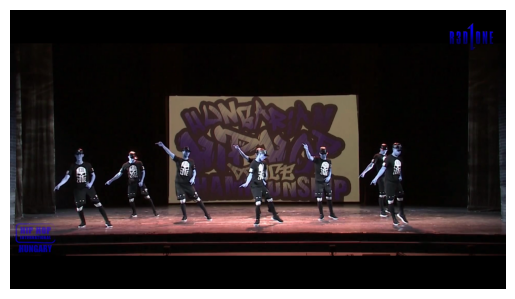

In [ ]:
org_img = cv2.imread(frame_path)

import matplotlib.pyplot as plt
plt.imshow(org_img)
plt.axis('off')  # Hide axes
plt.show()